In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from typing import Optional, List
from moseq2_nlp.data import load_groups, get_transition_representation, get_transition_representations_n, sample_markov_chain
from moseq2_nlp.train import train_regressor, train_svm
from moseq2_viz.util import parse_index
from moseq2_viz.model.util import (get_transition_matrix,
                                   parse_model_results,
                                   results_to_dataframe,
                                   relabel_by_usage, get_syllable_statistics)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pdb
import os
from tqdm import tqdm
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
from moseq2_nlp.gridsearch import get_best_model, find_gridsearch_results

path = '/cs/labs/mornitzan/ricci/data/abraira/vibhu/vibhu_r21/gridsearch_results/2022-06-13_analysis_3w_only/moseq-nlp/results'

In [3]:
df = find_gridsearch_results(path)
embedding_df   = df.loc[df['representation'] == 'embeddings']
transitions_df = df.loc[df['representation'] == 'transitions']
usages_df      = df.loc[df['representation'] == 'usages']

In [4]:
# Load exp info

from moseq2_nlp.gridsearch import get_best_model, find_gridsearch_results

path = '/cs/labs/mornitzan/ricci/data/abraira/vibhu/vibhu_r21/gridsearch_results/2022-06-13_analysis_3w_only/moseq-nlp/results'

df = find_gridsearch_results(path)
best_embedding_exp = df.loc[df['representation'] == 'embeddings'].sort_values('best_accuracy', ascending=False).iloc[0]
best_transitions_exp = df.loc[df['representation'] == 'transitions'].sort_values('best_accuracy', ascending=False).iloc[0]
best_usages_exp  = df.loc[df['representation'] == 'usages'].sort_values('best_accuracy', ascending=False).iloc[0]

In [6]:
# Get all representations
from moseq2_nlp.data import load_groups, get_raw_data, get_usage_representation, get_transition_representation
from moseq2_nlp.models import DocumentEmbedding

model_file       = '/cs/labs/mornitzan/ricci/data/abraira/vibhu/vibhu_r21/3w_rOT_model_1000.p'
index_file       = '/cs/labs/mornitzan/ricci/data/abraira/vibhu/vibhu_r21/moseq2-index.3w.grouped.yaml'
max_syllable     = best_embedding_exp['num_syllables']
num_transitions  = best_transitions_exp['num_transitions']
dm               = best_embedding_exp['dm']
embedding_epochs = best_embedding_exp['embedding_epochs']
embedding_window = best_embedding_exp['embedding_window']
embedding_dim    = best_embedding_exp['embedding_dim']
min_count        = best_embedding_exp['min_count']
bad_syllables    = best_embedding_exp['bad_syllables']
emissions        = best_embedding_exp['emissions']
de_path          = os.path.join('/cs/labs/mornitzan/ricci/data/abraira/vibhu/vibhu_r21', 'gridsearch_results/2022-06-13_analysis_3w_only/moseq-nlp/results',best_embedding_exp['name'],'doc2vec')

group_map = load_groups(index_file, [])
sentences, labels = get_raw_data(model_file, index_file,max_syllable=max_syllable, emissions=emissions, bad_syllables=bad_syllables)
_, U = get_usage_representation(model_file, index_file, group_map, max_syllable=max_syllable)
_, T = get_transition_representation(model_file, index_file, group_map, num_transitions, max_syllable=max_syllable)
de = DocumentEmbedding(dm, embedding_dim, embedding_window, embedding_epochs, min_count)
de.load(de_path)
print('Inferring embeddings...')
E = de.predict(sentences)


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 330.14it/s]


Inferring embeddings...


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

seed=best_embedding_exp['seed']
num_c = best_embedding_exp['num_c']
K = 10 # K-fold cross-validation
all_C = np.logspace(-5,5, num=num_c)
stratified = False
num_splits = 10
penalty = 'l2'
num_animals = E.shape[0]
custom_groupings = {0:0, 1:1, 2:1}

# Permute training data
perm_ind = np.random.permutation(num_animals)
perm_E = np.array(E)#[perm_ind,:]
perm_U = U#[perm_ind,:]
perm_T  = T#[perm_ind,:]

unique_labels = []
for label in labels:
    if label not in unique_labels:
        unique_labels.append(label)
label_nums = []
for label in labels:
    ind = unique_labels.index(label)
    if custom_groupings is not None:
        label_nums.append(custom_groupings[ind])
    else:
        label_nums.append(ind)
        
num_label_nums = len(np.unique(label_nums))
perm_labels = np.array(label_nums)#[perm_ind]
if stratified:
#     skf = StratifiedKFold(n_splits=num_splits) 
    skf = StratifiedShuffleSplit(n_splits=num_splits)
else:
    num_splits = int(num_animals / float(K))

accs_per_C = []
accs_per_C_std = []
cms_per_C = []
accs_per_rep = []
names = ['Usages', 'Transitions', 'Embeddings']
# For each representation
for C in tqdm(all_C):
    accs = [[],[],[]]
    cms  = 3*[np.zeros((num_label_nums,num_label_nums))]
    for j, (nm, rep) in enumerate(zip(names,[perm_U, perm_T, perm_E])):
        if stratified:
            skf.get_n_splits(rep,label_nums)
            stratified_splits = [split for split in skf.split(rep,label_nums)]
        # For each split
        for i in range(num_splits):
#             print(i)
            # New split of data and labels
            if stratified:
                train_inds, test_inds = stratified_splits[i]
                train_X, test_X = rep[train_inds], rep[test_inds]
                train_y, test_y = perm_labels[train_inds], perm_labels[test_inds]
#                 test_y_inds = [unique_labels.index(lb) for lb in test_y]
                test_y_inds = test_y

            else:
                shifted_rep = np.roll(rep, i*K, axis=0)
                shifted_labels = np.roll(perm_labels, i*K, axis=0)

                # Split into train and test
                train_X, train_y = shifted_rep[K:,:], shifted_labels[K:]
                test_X, test_y = shifted_rep[:K,:], shifted_labels[:K]
#                 test_y_inds = [unique_labels.index(lb) for lb in test_y]
                test_y_inds = test_y
            # Load and train classifier
            if penalty != 'none':
                clf = LogisticRegression(random_state=seed,dual=False,solver='lbfgs', penalty=penalty,class_weight='balanced',
                                     multi_class='auto',C=C, tol=1e-6, max_iter=2000).fit(train_X, train_y)
            else:
                clf = LogisticRegression(random_state=seed,dual=False,solver='lbfgs',class_weight='balanced',
                         multi_class='auto', tol=1e-6, max_iter=2000).fit(train_X, train_y)
            # Predict on held-out data
            y_pred = clf.predict(test_X)
#             pred_y_inds = [unique_labels.index(lb) for lb in y_pred]
            pred_y_inds = y_pred
            # Store average accuracy on test set for this split for this representation
            accs[j].append(np.mean(1*(y_pred == test_y)))
            for l, (true, pred) in enumerate(zip(test_y_inds, pred_y_inds)):
                cms[j][true,pred] += 1
    cms_per_C.append(np.array(cms))
    accs_per_C.append(np.array(accs).mean(-1))
    accs_per_C_std.append(np.array(accs).std(-1))
cms_per_C = np.array(cms_per_C)


  0%|                                                                                            | 0/11 [00:00<?, ?it/s]/cs/usr/ricci/anaconda3/envs/moseq2-nlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.96it/s]


In [9]:
print(unique_labels)

['Fezf2_KO_3w', 'Fezf2_het_3w', 'Fezf2_wt_3w']


/tmp/ipykernel_30133/2322963825.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax, orientation='vertical')


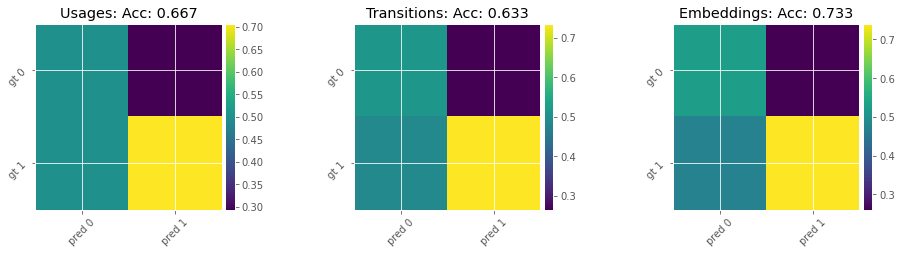

In [19]:
# num_c x reps x classes x classes
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1,3, figsize=(15,5))
accs_per_C = np.array(accs_per_C)
for nm, i in zip(['Usages', 'Transitions', 'Embeddings'],range(3)):
    rep_accs = accs_per_C[:,i]
    rep_cms = cms_per_C[:,i]
    best_cm = rep_cms[np.argmax(rep_accs)]
    normalized_mx = best_cm/best_cm.sum(0)
    im = axes[i].imshow(normalized_mx)
    best_acc = np.max(rep_accs)
#     print(best_acc)
    axes[i].set_title(nm + f': Acc: {best_acc:.3f}')
    axes[i].set_xticks(range(num_label_nums))
    axes[i].set_yticks(range(num_label_nums))
    axes[i].set_xticklabels(['pred ' + str(ul) for ul in range(num_label_nums)], rotation=45)
    axes[i].set_yticklabels(['gt ' + str(ul) for ul in range(num_label_nums)],rotation=45)
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.subplots_adjust(wspace=.6)
plt.show()

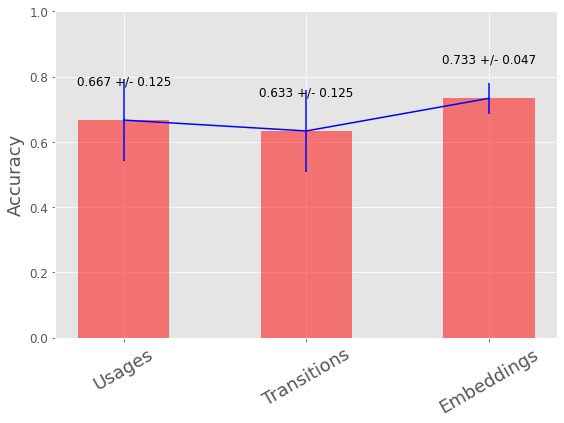

In [41]:
best_C_inds = np.argmax(accs_per_C,axis=0)
accs_per_C_std = np.array(accs_per_C_std)
best_accs = [accs_per_C[best_C_inds[i],i] for i in range(3)]
best_stds = [accs_per_C_std[best_C_inds[i],i] for i in range(3)]
fig, ax = plt.subplots(figsize=(9,6))
bar_labels = ['Usages', 'Transitions', 'Embeddings']
bars = plt.bar([0,1,2],best_accs,width=.5,color='r',alpha=.5)
plt.errorbar([0,1,2],best_accs, yerr=best_stds,color='blue')
ax.set_xticks([0,1,2])
ax.set_ylim([0,1.0])
ax.set_xticklabels(bar_labels, rotation=30, fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)

for r, rect in enumerate(bars):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2.0, height + .1, f'{height:.3f} +/- {best_stds[r]:.3f}', ha='center', va='bottom', fontsize=12)

plt.yticks(fontsize=12)
plt.show()
plt.close()

In [38]:
accs_per_C

array([[0.55 , 0.525, 0.6  ],
       [0.6  , 0.525, 0.6  ],
       [0.5  , 0.525, 0.575],
       [0.575, 0.525, 0.55 ],
       [0.5  , 0.5  , 0.55 ],
       [0.525, 0.45 , 0.6  ],
       [0.5  , 0.55 , 0.6  ],
       [0.375, 0.45 , 0.7  ],
       [0.5  , 0.6  , 0.675],
       [0.525, 0.575, 0.525],
       [0.425, 0.5  , 0.525]])

In [39]:
accs_per_C_std

array([[0.15      , 0.175     , 0.2       ],
       [0.12247449, 0.13462912, 0.16583124],
       [0.15811388, 0.175     , 0.225     ],
       [0.19525624, 0.13462912, 0.15      ],
       [0.19364917, 0.15811388, 0.15      ],
       [0.13462912, 0.24494897, 0.27838822],
       [0.15811388, 0.15      , 0.25495098],
       [0.20155644, 0.15      , 0.26925824],
       [0.2236068 , 0.16583124, 0.16007811],
       [0.13462912, 0.16007811, 0.175     ],
       [0.16007811, 0.2236068 , 0.28394542]])